In [10]:
import pandas as pd
import numpy as np
import re
import string
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Flatten, Concatenate, Dropout

2024-08-19 05:53:58.386383: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-19 05:53:58.386494: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-19 05:53:58.514766: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [24]:
df=pd.read_csv("/kaggle/input/finaldata/cleanedDataset.csv")

In [25]:
df

,Thought,Label,word_count,unique_word_count,stop_word_count,url_count,mean_word_length,char_count,punctuation_count,hashtag_count,mention_count,length_of_Thought
0,everyon probabl mad,negative,3,3,0,0,6.333333,21,0,0,0,21
1,braver believ,positive,2,2,0,0,6.500000,14,0,0,0,14
2,open eye want see,positive,4,4,0,0,3.750000,18,0,0,0,18
3,clearli dont want friend anymor,negative,5,5,0,0,5.800000,33,0,0,0,33
4,never done befor,negative,3,3,1,0,5.000000,17,0,0,0,17
...,...,...,...,...,...,...,...,...,...,...,...,...
156780,believ fast time fli,negative,4,4,0,0,5.000000,23,0,0,0,23
156781,eat spici food,negative,3,3,0,0,4.000000,14,0,0,0,14
156782,itâ OK screw Up nigel raw,positive,6,6,1,0,3.500000,26,0,0,0,26
156783,itâ here itâ beauti itâ sign fit right in,positive,9,7,2,0,4.666667,50,0,0,0,50


In [26]:
df = df[['Thought', 'Label']]

In [27]:
df

,Thought,Label
0,everyon probabl mad,negative
1,braver believ,positive
2,open eye want see,positive
3,clearli dont want friend anymor,negative
4,never done befor,negative
...,...,...
156780,believ fast time fli,negative
156781,eat spici food,negative
156782,itâ OK screw Up nigel raw,positive
156783,itâ here itâ beauti itâ sign fit right in,positive


In [28]:
nan_counts_per_column = df.isna().sum()
print("NaN counts per column:")
print(nan_counts_per_column)

NaN counts per column:
Thought    79
Label       0
dtype: int64


In [29]:
# Count total NaN values in the entire DataFrame
total_nan_count = df.isna().sum().sum()
print("\nTotal NaN values in the DataFrame:")
print(total_nan_count)


Total NaN values in the DataFrame:
79


In [30]:
df = df.dropna()

In [31]:
# Count total NaN values in the entire DataFrame
df['Thought'] = df['Thought'].str.lower()
total_nan_count = df.isna().sum().sum()
print("\nTotal NaN values in the DataFrame:")
print(total_nan_count)
df


Total NaN values in the DataFrame:
0


/tmp/ipykernel_34/881237108.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Thought'] = df['Thought'].str.lower()


,Thought,Label
0,everyon probabl mad,negative
1,braver believ,positive
2,open eye want see,positive
3,clearli dont want friend anymor,negative
4,never done befor,negative
...,...,...
156780,believ fast time fli,negative
156781,eat spici food,negative
156782,itâ ok screw up nigel raw,positive
156783,itâ here itâ beauti itâ sign fit right in,positive


In [34]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Bidirectional, Concatenate, GlobalMaxPooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

class TextClassificationModel:
    def __init__(self, df, max_len=600, embedding_dim=128):
        self.df = df
        self.max_len = max_len
        self.embedding_dim = embedding_dim
        self.tokenizer = Tokenizer()
        self.label_encoder = LabelEncoder()

    def preprocess_data(self, split=0.2):
        # Encode the labels
        self.df['Thought'] = self.df['Thought'].astype(str)
        self.df['Label'] = self.label_encoder.fit_transform(self.df['Label'])

        # Split the data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(self.df['Thought'], self.df['Label'], test_size=split, random_state=42)

        # Tokenize the text
        self.tokenizer.fit_on_texts(X_train)
        X_train_seq = self.tokenizer.texts_to_sequences(X_train)
        X_test_seq = self.tokenizer.texts_to_sequences(X_test)

        # Pad the sequences
        X_train_pad = pad_sequences(X_train_seq, maxlen=self.max_len)
        X_test_pad = pad_sequences(X_test_seq, maxlen=self.max_len)

        return X_train_pad, X_test_pad, y_train, y_test

    def build_model(self):
        # Define the input layer
        input_layer = Input(shape=(self.max_len,))

        # Embedding layer
        embedding_layer = Embedding(input_dim=len(self.tokenizer.word_index) + 1, output_dim=self.embedding_dim)(input_layer)

        # CNN part
        conv_layer = Conv1D(filters=128, kernel_size=5, activation='relu')(embedding_layer)
        pooling_layer = GlobalMaxPooling1D()(conv_layer)

        # BiLSTM part
        bilstm_layer = Bidirectional(LSTM(128, return_sequences=False))(embedding_layer)

        # Concatenate CNN and BiLSTM outputs
        concat_layer = Concatenate()([pooling_layer, bilstm_layer]) 

        # Add Dense layers
        dense_layer = Dense(128, activation='relu')(concat_layer)
        dropout_layer = Dropout(0.5)(dense_layer)
        output_layer = Dense(1, activation='sigmoid')(dropout_layer)

        # Build the model
        model = Model(inputs=input_layer, outputs=output_layer)
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

        return model

    def train_model(self, model, X_train_pad, y_train, X_test_pad, y_test, epochs=10, batch_size=64):
        history = model.fit(X_train_pad, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test_pad, y_test))
        return history

    def plot_history(self, history):
        plt.figure(figsize=(14, 5))
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'], label='Training Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title('Model Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title('Model Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

    def evaluate_model(self, model, X_test_pad, y_test):
        loss, accuracy = model.evaluate(X_test_pad, y_test)
        print(f'Test Accuracy: {accuracy * 100:.2f}%')
        return accuracy

    def extract_features(self, model, X_train_pad, X_test_pad):
        feature_extractor = Model(inputs=model.input, outputs=model.get_layer('dense_17').output)
        X_train_features = feature_extractor.predict(X_train_pad)
        X_test_features = feature_extractor.predict(X_test_pad)
        return X_train_features, X_test_features

    def train_logistic_regression(self, X_train_features, y_train):
        lr_model = LogisticRegression(max_iter=1000)
        lr_model.fit(X_train_features, y_train)
        return lr_model

    def evaluate_logistic_regression(self, lr_model, X_test_features, y_test):
        y_pred = lr_model.predict(X_test_features)
        target_names = [str(cls) for cls in self.label_encoder.classes_]
        print(classification_report(y_test, y_pred, target_names=target_names))


# Test/Train 10-90

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 600)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 600, 128)  │  5,123,456 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 596, 128)  │     82,048 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d_1[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 256)       │    263,168 │ embedding_1[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 384)       │          0 │ global_max_pooli… │
│ (Concatenate)       │                   │            │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │     49,280 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │        129 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,518,081 (21.05 MB)

 Trainable params: 5,518,081 (21.05 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
2204/2204 ━━━━━━━━━━━━━━━━━━━━ 176s 79ms/step - accuracy: 0.8626 - loss: 0.3031 - val_accuracy: 0.9468 - val_loss: 0.1517
Epoch 2/10
2204/2204 ━━━━━━━━━━━━━━━━━━━━ 173s 78ms/step - accuracy: 0.9646 - loss: 0.1007 - val_accuracy: 0.9545 - val_loss: 0.1396
Epoch 3/10
2204/2204 ━━━━━━━━━━━━━━━━━━━━ 173s 78ms/step - accuracy: 0.9825 - loss: 0.0510 - val_accuracy: 0.9514 - val_loss: 0.1641
Epoch 4/10
2204/2204 ━━━━━━━━━━━━━━━━━━━━ 173s 78ms/step - accuracy: 0.9896 - loss: 0.0301 - val_accuracy: 0.9486 - val_loss: 0.2176
Epoch 5/10
2204/2204 ━━━━━━━━━━━━━━━━━━━━ 173s 78ms/step - accuracy: 0.9926 - loss: 0.0211 - val_accuracy: 0.9478 - val_loss: 0.2531
Epoch 6/10
2204/2204 ━━━━━━━━━━━━━━━━━━━━ 173s 79ms/step - accuracy: 0.9938 - loss: 0.0167 - val_accuracy: 0.9496 - val_loss: 0.2825
Epoch 7/10
2204/2204 ━━━━━━━━━━━━━━━━━━━━ 172s 78ms/step - accuracy: 0.9949 - loss: 0.0138 - val_accuracy: 0.9518 - val_loss: 0.2948
Epoch 8/10
2204/2204 ━━━━━━━━━━━━━━━━━━━━ 172s 78ms/step - accuracy: 

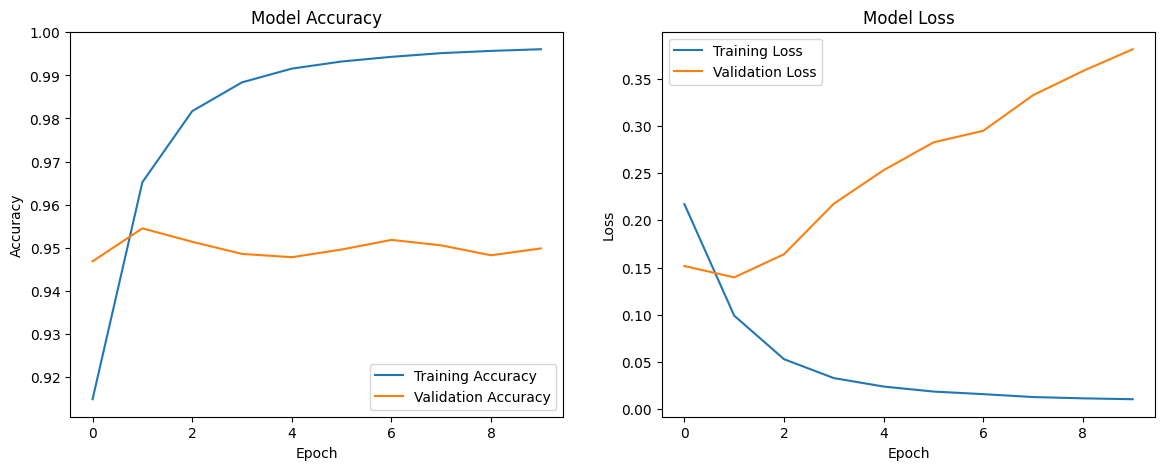

490/490 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - accuracy: 0.9493 - loss: 0.3781
Test Accuracy: 94.98%


0.9498436450958252

In [13]:
# Usage

split_ratio = 0.1

model_obj = TextClassificationModel(df)
X_train_pad, X_test_pad, y_train, y_test = model_obj.preprocess_data(split=split_ratio)
model = model_obj.build_model()
model.summary()
history = model_obj.train_model(model, X_train_pad, y_train, X_test_pad, y_test)
model_obj.plot_history(history)
model_obj.evaluate_model(model, X_test_pad, y_test)

In [16]:
X_train_features, X_test_features = model_obj.extract_features(model, X_train_pad, X_test_pad)
lr_model = model_obj.train_logistic_regression(X_train_features, y_train)
model_obj.evaluate_logistic_regression(lr_model, X_test_features, y_test)

4408/4408 ━━━━━━━━━━━━━━━━━━━━ 123s 28ms/step
490/490 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step
              precision    recall  f1-score   support

           0       0.95      0.94      0.95      7208
           1       0.95      0.96      0.95      8463

    accuracy                           0.95     15671
   macro avg       0.95      0.95      0.95     15671
weighted avg       0.95      0.95      0.95     15671



/tmp/ipykernel_34/2111423456.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df['Thought'] = self.df['Thought'].astype(str)
/tmp/ipykernel_34/2111423456.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df['Label'] = self.label_encoder.fit_transform(self.df['Label'])


Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 120)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_9         │ (None, 120, 128)  │  5,123,456 │ input_layer_9[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_11 (Conv1D)  │ (None, 116, 128)  │     82,048 │ embedding_9[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d_11[0][0]   │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_8     │ (None, 256)       │    263,168 │ embedding_9[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_8       │ (None, 384)       │          0 │ global_max_pooli… │
│ (Concatenate)       │                   │            │ bidirectional_8[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 128)       │     49,280 │ concatenate_8[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 128)       │          0 │ dense_16[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_17 (Dense)    │ (None, 1)         │        129 │ dropout_8[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,518,081 (21.05 MB)

 Trainable params: 5,518,081 (21.05 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
2204/2204 ━━━━━━━━━━━━━━━━━━━━ 50s 21ms/step - accuracy: 0.8594 - loss: 0.3044 - val_accuracy: 0.9437 - val_loss: 0.1573
Epoch 2/10
2204/2204 ━━━━━━━━━━━━━━━━━━━━ 47s 21ms/step - accuracy: 0.9659 - loss: 0.1001 - val_accuracy: 0.9500 - val_loss: 0.1444
Epoch 3/10
2204/2204 ━━━━━━━━━━━━━━━━━━━━ 47s 21ms/step - accuracy: 0.9820 - loss: 0.0527 - val_accuracy: 0.9491 - val_loss: 0.1684
Epoch 4/10
2204/2204 ━━━━━━━━━━━━━━━━━━━━ 47s 21ms/step - accuracy: 0.9894 - loss: 0.0299 - val_accuracy: 0.9512 - val_loss: 0.1915
Epoch 5/10
2204/2204 ━━━━━━━━━━━━━━━━━━━━ 47s 21ms/step - accuracy: 0.9924 - loss: 0.0213 - val_accuracy: 0.9476 - val_loss: 0.2521
Epoch 6/10
2204/2204 ━━━━━━━━━━━━━━━━━━━━ 47s 21ms/step - accuracy: 0.9938 - loss: 0.0181 - val_accuracy: 0.9451 - val_loss: 0.2528
Epoch 7/10
2204/2204 ━━━━━━━━━━━━━━━━━━━━ 47s 21ms/step - accuracy: 0.9950 - loss: 0.0139 - val_accuracy: 0.9459 - val_loss: 0.3161
Epoch 8/10
2204/2204 ━━━━━━━━━━━━━━━━━━━━ 47s 21ms/step - accuracy: 0.9954 -

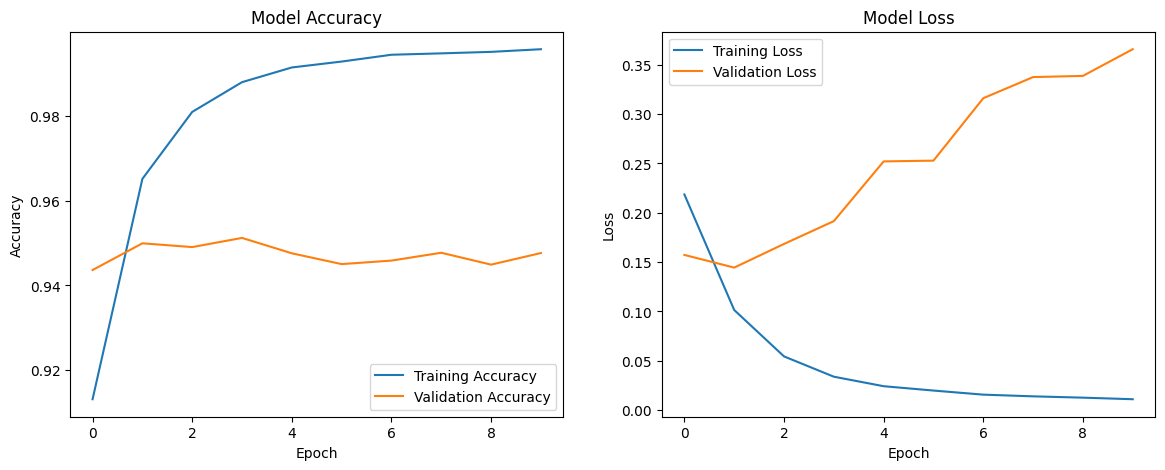

490/490 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9462 - loss: 0.3770
Test Accuracy: 94.77%
2656/4408 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step

In [ ]:
# Usage

split_ratio = 0.1
max_len = 120

model_obj = TextClassificationModel(df, max_len)
X_train_pad, X_test_pad, y_train, y_test = model_obj.preprocess_data(split=split_ratio)
model = model_obj.build_model()
model.summary()
history = model_obj.train_model(model, X_train_pad, y_train, X_test_pad, y_test)
model_obj.plot_history(history)
model_obj.evaluate_model(model, X_test_pad, y_test)
X_train_features, X_test_features = model_obj.extract_features(model, X_train_pad, X_test_pad)
lr_model = model_obj.train_logistic_regression(X_train_features, y_train)
model_obj.evaluate_logistic_regression(lr_model, X_test_features, y_test)

# Test/Train 15-85

/tmp/ipykernel_34/3769100378.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df['Thought'] = self.df['Thought'].astype(str)
/tmp/ipykernel_34/3769100378.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df['Label'] = self.label_encoder.fit_transform(self.df['Label'])


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 600)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 600, 128)  │  4,998,016 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 596, 128)  │     82,048 │ embedding_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d_2[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_2     │ (None, 256)       │    263,168 │ embedding_2[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 384)       │          0 │ global_max_pooli… │
│ (Concatenate)       │                   │            │ bidirectional_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 128)       │     49,280 │ concatenate_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128)       │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1)         │        129 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,392,641 (20.57 MB)

 Trainable params: 5,392,641 (20.57 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
2082/2082 ━━━━━━━━━━━━━━━━━━━━ 172s 82ms/step - accuracy: 0.8562 - loss: 0.3130 - val_accuracy: 0.9437 - val_loss: 0.1592
Epoch 2/10
2082/2082 ━━━━━━━━━━━━━━━━━━━━ 170s 81ms/step - accuracy: 0.9651 - loss: 0.0993 - val_accuracy: 0.9497 - val_loss: 0.1487
Epoch 3/10
2082/2082 ━━━━━━━━━━━━━━━━━━━━ 170s 81ms/step - accuracy: 0.9822 - loss: 0.0509 - val_accuracy: 0.9480 - val_loss: 0.1812
Epoch 4/10
2082/2082 ━━━━━━━━━━━━━━━━━━━━ 202s 81ms/step - accuracy: 0.9890 - loss: 0.0314 - val_accuracy: 0.9485 - val_loss: 0.2245
Epoch 5/10
2082/2082 ━━━━━━━━━━━━━━━━━━━━ 170s 82ms/step - accuracy: 0.9922 - loss: 0.0217 - val_accuracy: 0.9474 - val_loss: 0.2850
Epoch 6/10
2082/2082 ━━━━━━━━━━━━━━━━━━━━ 170s 81ms/step - accuracy: 0.9937 - loss: 0.0176 - val_accuracy: 0.9499 - val_loss: 0.2643
Epoch 7/10
2082/2082 ━━━━━━━━━━━━━━━━━━━━ 169s 81ms/step - accuracy: 0.9949 - loss: 0.0143 - val_accuracy: 0.9462 - val_loss: 0.3224
Epoch 8/10
2082/2082 ━━━━━━━━━━━━━━━━━━━━ 169s 81ms/step - accuracy: 

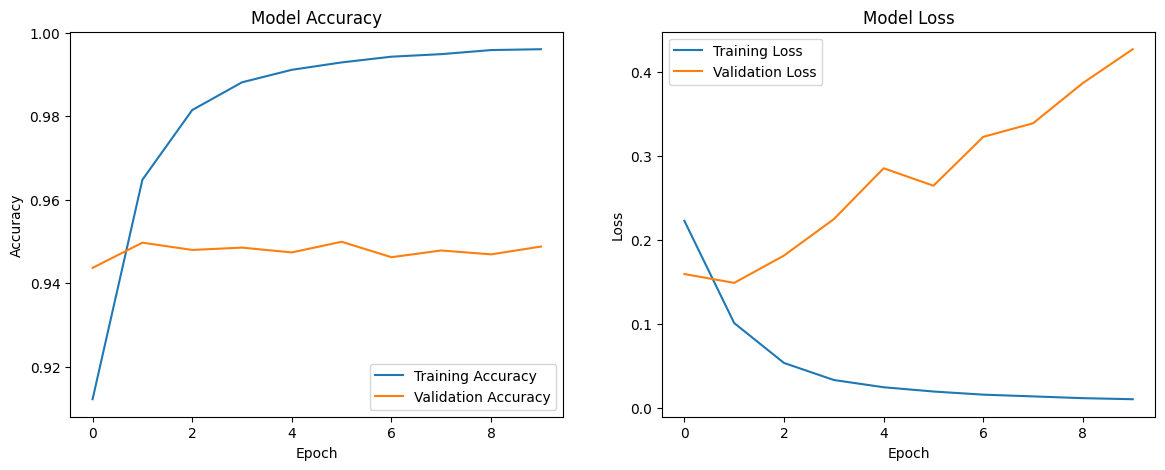

735/735 ━━━━━━━━━━━━━━━━━━━━ 21s 29ms/step - accuracy: 0.9490 - loss: 0.4251
Test Accuracy: 94.88%
4163/4163 ━━━━━━━━━━━━━━━━━━━━ 117s 28ms/step
735/735 ━━━━━━━━━━━━━━━━━━━━ 21s 28ms/step
              precision    recall  f1-score   support

           0       0.94      0.94      0.94     10739
           1       0.95      0.95      0.95     12767

    accuracy                           0.95     23506
   macro avg       0.95      0.95      0.95     23506
weighted avg       0.95      0.95      0.95     23506



In [20]:
# Usage
split_ratio = 0.15

model_obj = TextClassificationModel(df)
X_train_pad, X_test_pad, y_train, y_test = model_obj.preprocess_data(split=split_ratio)
model = model_obj.build_model()
model.summary()

history = model_obj.train_model(model, X_train_pad, y_train, X_test_pad, y_test)
model_obj.plot_history(history)
model_obj.evaluate_model(model, X_test_pad, y_test)
X_train_features, X_test_features = model_obj.extract_features(model, X_train_pad, X_test_pad)
lr_model = model_obj.train_logistic_regression(X_train_features, y_train)
model_obj.evaluate_logistic_regression(lr_model, X_test_features, y_test)

# Test/Train 20-80

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 600)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 600, 128)  │  4,862,592 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 596, 128)  │     82,048 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d[0][0]      │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 256)       │    263,168 │ embedding[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 384)       │          0 │ global_max_pooli… │
│ (Concatenate)       │                   │            │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     49,280 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │        129 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,257,217 (20.05 MB)

 Trainable params: 5,257,217 (20.05 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1959/1959 ━━━━━━━━━━━━━━━━━━━━ 169s 83ms/step - accuracy: 0.8557 - loss: 0.3145 - val_accuracy: 0.9415 - val_loss: 0.1626
Epoch 2/10
1959/1959 ━━━━━━━━━━━━━━━━━━━━ 161s 82ms/step - accuracy: 0.9640 - loss: 0.1031 - val_accuracy: 0.9481 - val_loss: 0.1627
Epoch 3/10
1959/1959 ━━━━━━━━━━━━━━━━━━━━ 161s 82ms/step - accuracy: 0.9831 - loss: 0.0488 - val_accuracy: 0.9439 - val_loss: 0.1917
Epoch 4/10
1959/1959 ━━━━━━━━━━━━━━━━━━━━ 162s 82ms/step - accuracy: 0.9897 - loss: 0.0302 - val_accuracy: 0.9469 - val_loss: 0.2109
Epoch 5/10
1959/1959 ━━━━━━━━━━━━━━━━━━━━ 161s 82ms/step - accuracy: 0.9923 - loss: 0.0221 - val_accuracy: 0.9473 - val_loss: 0.2634
Epoch 6/10
1959/1959 ━━━━━━━━━━━━━━━━━━━━ 162s 82ms/step - accuracy: 0.9941 - loss: 0.0159 - val_accuracy: 0.9466 - val_loss: 0.2900
Epoch 7/10
1959/1959 ━━━━━━━━━━━━━━━━━━━━ 161s 82ms/step - accuracy: 0.9951 - loss: 0.0143 - val_accuracy: 0.9470 - val_loss: 0.3103
Epoch 8/10
1959/1959 ━━━━━━━━━━━━━━━━━━━━ 161s 82ms/step - accuracy: 

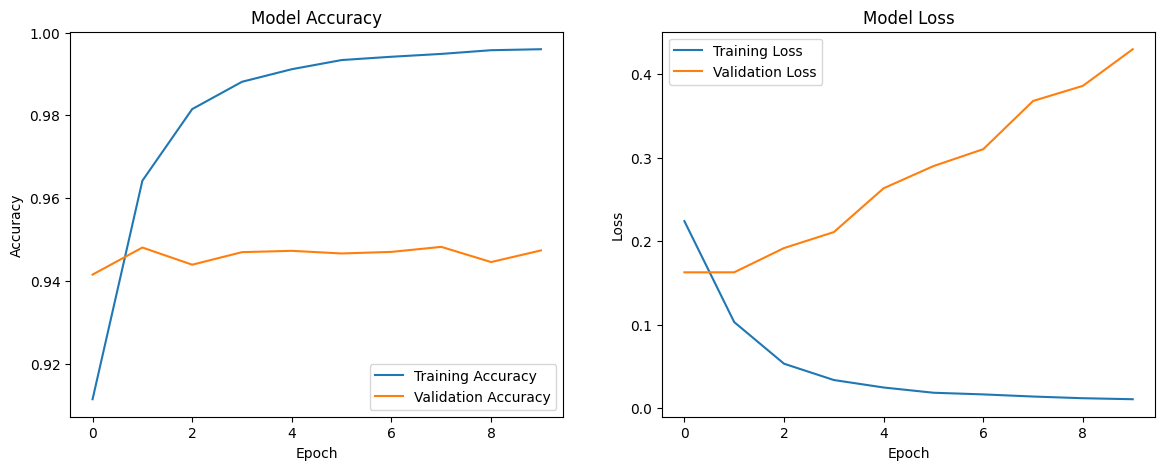

980/980 ━━━━━━━━━━━━━━━━━━━━ 27s 28ms/step - accuracy: 0.9466 - loss: 0.4309
Test Accuracy: 94.74%
3918/3918 ━━━━━━━━━━━━━━━━━━━━ 109s 28ms/step
980/980 ━━━━━━━━━━━━━━━━━━━━ 27s 28ms/step
              precision    recall  f1-score   support

    negative       0.94      0.95      0.94     14237
    positive       0.96      0.95      0.95     17105

    accuracy                           0.95     31342
   macro avg       0.95      0.95      0.95     31342
weighted avg       0.95      0.95      0.95     31342



In [11]:
# Usage
split_ratio = 0.2

model_obj = TextClassificationModel(df)
X_train_pad, X_test_pad, y_train, y_test = model_obj.preprocess_data(split=split_ratio)
model = model_obj.build_model()
model.summary()

history = model_obj.train_model(model, X_train_pad, y_train, X_test_pad, y_test)
model_obj.plot_history(history)
model_obj.evaluate_model(model, X_test_pad, y_test)

X_train_features, X_test_features = model_obj.extract_features(model, X_train_pad, X_test_pad)
lr_model = model_obj.train_logistic_regression(X_train_features, y_train)
model_obj.evaluate_logistic_regression(lr_model, X_test_features, y_test)

# Test/Train 25-70

/tmp/ipykernel_34/2330316978.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df['Thought'] = self.df['Thought'].astype(str)
/tmp/ipykernel_34/2330316978.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df['Label'] = self.label_encoder.fit_transform(self.df['Label'])


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 600)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, 600, 128)  │  4,717,568 │ input_layer_3[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 596, 128)  │     82,048 │ embedding_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d_3[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_3     │ (None, 256)       │    263,168 │ embedding_3[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 384)       │          0 │ global_max_pooli… │
│ (Concatenate)       │                   │            │ bidirectional_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 128)       │     49,280 │ concatenate_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 128)       │          0 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 1)         │        129 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,112,193 (19.50 MB)

 Trainable params: 5,112,193 (19.50 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1837/1837 ━━━━━━━━━━━━━━━━━━━━ 161s 87ms/step - accuracy: 0.8487 - loss: 0.3231 - val_accuracy: 0.9425 - val_loss: 0.1583
Epoch 2/10
1837/1837 ━━━━━━━━━━━━━━━━━━━━ 158s 86ms/step - accuracy: 0.9647 - loss: 0.1033 - val_accuracy: 0.9457 - val_loss: 0.1585
Epoch 3/10
1837/1837 ━━━━━━━━━━━━━━━━━━━━ 158s 86ms/step - accuracy: 0.9817 - loss: 0.0523 - val_accuracy: 0.9476 - val_loss: 0.1861
Epoch 4/10
1837/1837 ━━━━━━━━━━━━━━━━━━━━ 158s 86ms/step - accuracy: 0.9889 - loss: 0.0320 - val_accuracy: 0.9464 - val_loss: 0.2122
Epoch 5/10
1837/1837 ━━━━━━━━━━━━━━━━━━━━ 158s 86ms/step - accuracy: 0.9921 - loss: 0.0227 - val_accuracy: 0.9471 - val_loss: 0.2574
Epoch 6/10
1837/1837 ━━━━━━━━━━━━━━━━━━━━ 158s 86ms/step - accuracy: 0.9941 - loss: 0.0173 - val_accuracy: 0.9438 - val_loss: 0.2931
Epoch 7/10
1837/1837 ━━━━━━━━━━━━━━━━━━━━ 158s 86ms/step - accuracy: 0.9948 - loss: 0.0146 - val_accuracy: 0.9457 - val_loss: 0.3068
Epoch 8/10
1837/1837 ━━━━━━━━━━━━━━━━━━━━ 158s 86ms/step - accuracy: 

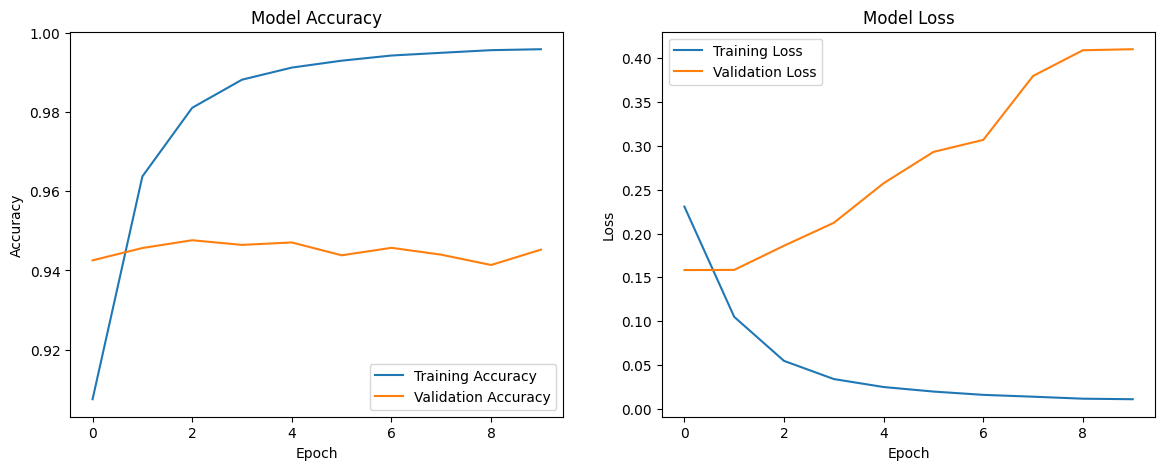

1225/1225 ━━━━━━━━━━━━━━━━━━━━ 35s 29ms/step - accuracy: 0.9457 - loss: 0.4170
Test Accuracy: 94.52%
3673/3673 ━━━━━━━━━━━━━━━━━━━━ 104s 28ms/step
1225/1225 ━━━━━━━━━━━━━━━━━━━━ 34s 28ms/step
              precision    recall  f1-score   support

           0       0.94      0.94      0.94     17774
           1       0.95      0.95      0.95     21403

    accuracy                           0.95     39177
   macro avg       0.94      0.94      0.94     39177
weighted avg       0.95      0.95      0.95     39177



In [22]:
# Usage
split_ratio = 0.25

model_obj = TextClassificationModel(df)
X_train_pad, X_test_pad, y_train, y_test = model_obj.preprocess_data(split=split_ratio)
model = model_obj.build_model()
model.summary()

history = model_obj.train_model(model, X_train_pad, y_train, X_test_pad, y_test)
model_obj.plot_history(history)
model_obj.evaluate_model(model, X_test_pad, y_test)

X_train_features, X_test_features = model_obj.extract_features(model, X_train_pad, X_test_pad)
lr_model = model_obj.train_logistic_regression(X_train_features, y_train)
model_obj.evaluate_logistic_regression(lr_model, X_test_features, y_test)

# Test/Train 30-70

/tmp/ipykernel_34/318843377.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df['Thought'] = self.df['Thought'].astype(str)
/tmp/ipykernel_34/318843377.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df['Label'] = self.label_encoder.fit_transform(self.df['Label'])


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 600)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_4         │ (None, 600, 128)  │  4,576,512 │ input_layer_4[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 596, 128)  │     82,048 │ embedding_4[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d_4[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_4     │ (None, 256)       │    263,168 │ embedding_4[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 384)       │          0 │ global_max_pooli… │
│ (Concatenate)       │                   │            │ bidirectional_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 128)       │     49,280 │ concatenate_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 128)       │          0 │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 1)         │        129 │ dropout_4[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,971,137 (18.96 MB)

 Trainable params: 4,971,137 (18.96 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1714/1714 ━━━━━━━━━━━━━━━━━━━━ 155s 89ms/step - accuracy: 0.8424 - loss: 0.3299 - val_accuracy: 0.9357 - val_loss: 0.1720
Epoch 2/10
1714/1714 ━━━━━━━━━━━━━━━━━━━━ 152s 89ms/step - accuracy: 0.9642 - loss: 0.1023 - val_accuracy: 0.9456 - val_loss: 0.1556
Epoch 3/10
1714/1714 ━━━━━━━━━━━━━━━━━━━━ 153s 89ms/step - accuracy: 0.9827 - loss: 0.0491 - val_accuracy: 0.9447 - val_loss: 0.1957
Epoch 4/10
1714/1714 ━━━━━━━━━━━━━━━━━━━━ 156s 91ms/step - accuracy: 0.9895 - loss: 0.0309 - val_accuracy: 0.9415 - val_loss: 0.2438
Epoch 5/10
1714/1714 ━━━━━━━━━━━━━━━━━━━━ 155s 91ms/step - accuracy: 0.9929 - loss: 0.0213 - val_accuracy: 0.9392 - val_loss: 0.2722
Epoch 6/10
1714/1714 ━━━━━━━━━━━━━━━━━━━━ 156s 91ms/step - accuracy: 0.9886 - loss: 0.0325 - val_accuracy: 0.9424 - val_loss: 0.2723
Epoch 7/10
1714/1714 ━━━━━━━━━━━━━━━━━━━━ 155s 90ms/step - accuracy: 0.9912 - loss: 0.0236 - val_accuracy: 0.9429 - val_loss: 0.3006
Epoch 8/10
1714/1714 ━━━━━━━━━━━━━━━━━━━━ 155s 91ms/step - accuracy: 

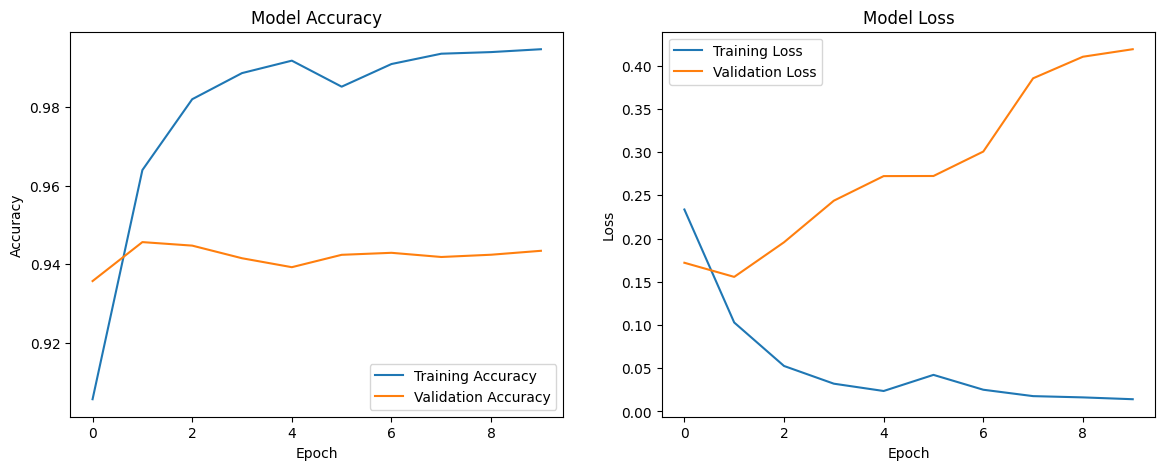

1470/1470 ━━━━━━━━━━━━━━━━━━━━ 43s 29ms/step - accuracy: 0.9445 - loss: 0.4217
Test Accuracy: 94.34%
3428/3428 ━━━━━━━━━━━━━━━━━━━━ 100s 29ms/step
1470/1470 ━━━━━━━━━━━━━━━━━━━━ 43s 29ms/step
              precision    recall  f1-score   support

           0       0.94      0.94      0.94     21379
           1       0.95      0.95      0.95     25633

    accuracy                           0.94     47012
   macro avg       0.94      0.94      0.94     47012
weighted avg       0.94      0.94      0.94     47012



In [24]:
# Usage
split_ratio = 0.3

model_obj = TextClassificationModel(df)
X_train_pad, X_test_pad, y_train, y_test = model_obj.preprocess_data(split=split_ratio)
model = model_obj.build_model()
model.summary()

history = model_obj.train_model(model, X_train_pad, y_train, X_test_pad, y_test)
model_obj.plot_history(history)
model_obj.evaluate_model(model, X_test_pad, y_test)

X_train_features, X_test_features = model_obj.extract_features(model, X_train_pad, X_test_pad)
lr_model = model_obj.train_logistic_regression(X_train_features, y_train)
model_obj.evaluate_logistic_regression(lr_model, X_test_features, y_test)

# Test/Train 35-65

/tmp/ipykernel_34/4048349363.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df['Thought'] = self.df['Thought'].astype(str)
/tmp/ipykernel_34/4048349363.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df['Label'] = self.label_encoder.fit_transform(self.df['Label'])


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 600)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_5         │ (None, 600, 128)  │  4,421,888 │ input_layer_5[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 596, 128)  │     82,048 │ embedding_5[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d_5[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_5     │ (None, 256)       │    263,168 │ embedding_5[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_5       │ (None, 384)       │          0 │ global_max_pooli… │
│ (Concatenate)       │                   │            │ bidirectional_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 128)       │     49,280 │ concatenate_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 128)       │          0 │ dense_10[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 1)         │        129 │ dropout_5[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,816,513 (18.37 MB)

 Trainable params: 4,816,513 (18.37 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1592/1592 ━━━━━━━━━━━━━━━━━━━━ 155s 96ms/step - accuracy: 0.8390 - loss: 0.3362 - val_accuracy: 0.9390 - val_loss: 0.1674
Epoch 2/10
1592/1592 ━━━━━━━━━━━━━━━━━━━━ 152s 96ms/step - accuracy: 0.9623 - loss: 0.1093 - val_accuracy: 0.9434 - val_loss: 0.1679
Epoch 3/10
1592/1592 ━━━━━━━━━━━━━━━━━━━━ 152s 96ms/step - accuracy: 0.9824 - loss: 0.0516 - val_accuracy: 0.9436 - val_loss: 0.2035
Epoch 4/10
1592/1592 ━━━━━━━━━━━━━━━━━━━━ 152s 95ms/step - accuracy: 0.9885 - loss: 0.0319 - val_accuracy: 0.9379 - val_loss: 0.2515
Epoch 5/10
1592/1592 ━━━━━━━━━━━━━━━━━━━━ 152s 95ms/step - accuracy: 0.9927 - loss: 0.0213 - val_accuracy: 0.9417 - val_loss: 0.2865
Epoch 6/10
1592/1592 ━━━━━━━━━━━━━━━━━━━━ 151s 95ms/step - accuracy: 0.9941 - loss: 0.0162 - val_accuracy: 0.9413 - val_loss: 0.2990
Epoch 7/10
1592/1592 ━━━━━━━━━━━━━━━━━━━━ 152s 95ms/step - accuracy: 0.9948 - loss: 0.0143 - val_accuracy: 0.9413 - val_loss: 0.3745
Epoch 8/10
1592/1592 ━━━━━━━━━━━━━━━━━━━━ 152s 95ms/step - accuracy: 

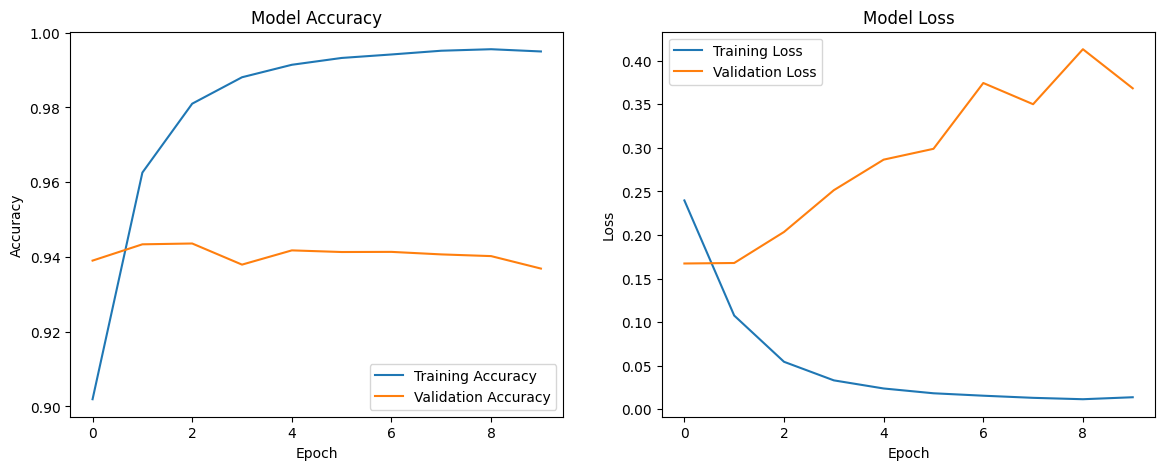

1714/1714 ━━━━━━━━━━━━━━━━━━━━ 51s 29ms/step - accuracy: 0.9371 - loss: 0.3749
Test Accuracy: 93.69%
3184/3184 ━━━━━━━━━━━━━━━━━━━━ 93s 29ms/step
1714/1714 ━━━━━━━━━━━━━━━━━━━━ 50s 29ms/step
              precision    recall  f1-score   support

           0       0.92      0.94      0.93     24956
           1       0.95      0.94      0.94     29892

    accuracy                           0.94     54848
   macro avg       0.94      0.94      0.94     54848
weighted avg       0.94      0.94      0.94     54848



In [26]:
# Usage
split_ratio = 0.35

model_obj = TextClassificationModel(df)
X_train_pad, X_test_pad, y_train, y_test = model_obj.preprocess_data(split=split_ratio)
model = model_obj.build_model()
model.summary()

history = model_obj.train_model(model, X_train_pad, y_train, X_test_pad, y_test)
model_obj.plot_history(history)
model_obj.evaluate_model(model, X_test_pad, y_test)

X_train_features, X_test_features = model_obj.extract_features(model, X_train_pad, X_test_pad)
lr_model = model_obj.train_logistic_regression(X_train_features, y_train)
model_obj.evaluate_logistic_regression(lr_model, X_test_features, y_test)

# bar

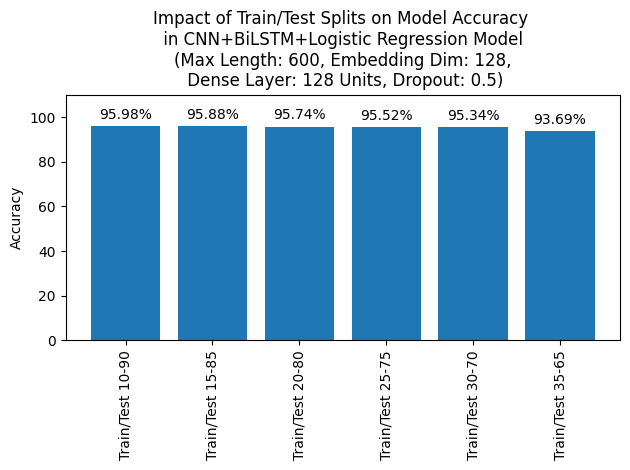

In [9]:
import matplotlib.pyplot as plt

models = ['Train/Test 10-90', 'Train/Test 15-85', 'Train/Test 20-80', 'Train/Test 25-75', 'Train/Test 30-70', 'Train/Test 35-65']
accuracies = [95.98, 95.88, 95.74, 95.52, 95.34, 93.69]

plt.bar(models, accuracies)
plt.ylabel('Accuracy')
plt.title(
    'Impact of Train/Test Splits on Model Accuracy \n in CNN+BiLSTM+Logistic Regression'
    ' Model \n(Max Length: 600, Embedding Dim: 128,\n Dense Layer: 128 Units, Dropout: 0.5)'
)
plt.xticks(rotation='vertical')

# Display the accuracies at the top of each bar
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 2, f'{acc:.2f}%', ha='center', va='bottom', fontsize=10)
plt.ylim(0, 110)
plt.tight_layout()
plt.show()
